# 1. Factor model to reduce dimentionality

$$\eta_t=\Phi \eta_{t-1} + \nu_t$$
$$x_t=\Lambda \eta_t + \epsilon_t$$

Where $\nu_t\sim \mathcal{N}_k(0,I)$ and $\epsilon_t\sim \mathcal{N}_p(0, \Sigma_0)$, with $k < p$. We can use the Kalman filter to estimate this model and fill missing values. The latent factors $\eta_t$ are going to be used to build the predictive model.

How can I add structure so that factors can represent elements of different frequency. In other words, elements that change at different paces.

In [1]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from src.d01_data.dengue_data_api import DengueDataApi
from src.d00_utils.utils import variable_analysis

In [2]:
from scipy import signal
dda = DengueDataApi(interpolate=False)
x1, x2, y1, y2 = dda.split_data(random=False)

In [3]:
np.isnan(x1).any().any()

True

In [4]:
from src.d04_modeling.dynamic_factor_model import DynamicFactorModel
from collections import defaultdict
factors = 3
factor_orders = 1
dfm_model = dict()    
dfm_model[(factors, factor_orders)] = DynamicFactorModel(x1.copy(), y1.copy(),
                                      factors=factors, factor_orders=factor_orders, idiosyncratic_ar1=True)
dfm_model[(factors, factor_orders)].fit()
dfm_model[(factors, factor_orders)].insample_model_evaluation()

,AIC,AICc,BIC
iq,5349.431789,5393.933691,5640.431656
sj,6645.000726,6665.041822,6986.526018


In [5]:
city = 'sj'
res_dfm = dfm_model[(factors, factor_orders)].get_model_results(city)
mod_dfm = dfm_model[(factors, factor_orders)].get_model(city)
res_dfm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               Dynamic Factor Results                              
===================================================================================
Dep. Variable:      "ndvi_ne", and 13 more   No. Observations:                  661
Model:                Dynamic Factor Model   Log Likelihood               -3246.500
                   + 3 factors in 3 blocks   AIC                           6645.001
                     + AR(1) idiosyncratic   BIC                           6986.526
Date:                     Mon, 29 Nov 2021   HQIC                          6777.369
Time:                             17:19:05   EM Iterations                      437
Sample:                         05-06-1990                                         
                              - 12-29-2002                                         
Covariance Type:              Not computed                                         
                                     Observation equation:                                      
================================================================================================
           Factor loadings:          0          1          2    idiosyncratic: AR(1)        var.
------------------------------------------------------------------------------------------------
                    ndvi_ne      -0.08      -0.04      -0.29                    0.40        0.57
                    ndvi_nw      -0.07      -0.03      -0.27                    0.46        0.57
                    ndvi_se      -0.03      -0.12      -0.23                    0.04        0.62
                    ndvi_sw      -0.03      -0.11      -0.23                    0.09        0.63
      reanalysis_air_temp_k       0.37      -0.16      -0.02                    0.34        0.00
      reanalysis_avg_temp_k       0.36      -0.17      -0.02                    0.15        0.00
reanalysis_dew_point_tem...       0.39       0.02      -0.06                    0.25        0.00
reanalysis_max_air_temp_...       0.35      -0.17       0.01                    0.21        0.13
reanalysis_min_air_temp_...       0.37      -0.10       0.00                    0.13        0.10
reanalysis_precip_amt_kg...       0.21       0.30       0.05                    0.25        0.33
reanalysis_relative_humi...       0.27       0.30      -0.11                    0.33        0.00
reanalysis_sat_precip_am...       0.18       0.18       0.15                    0.11        0.74
reanalysis_specific_humi...       0.39       0.02      -0.06                    0.55        0.00
          reanalysis_tdtr_k      -0.04      -0.26       0.02                    0.24        0.70
       Transition: Factor block 0      
=======================================
                 L1.0    error variance
---------------------------------------
         0       0.89              1.28
       Transition: Factor block 1      
=======================================
                 L1.1    error variance
---------------------------------------
         1       0.42              4.51
       Transition: Factor block 2      
=======================================
                 L1.2    error variance
---------------------------------------
         2       0.21              3.49
=======================================

Warnings:
[1] Covariance matrix not calculated.
"""

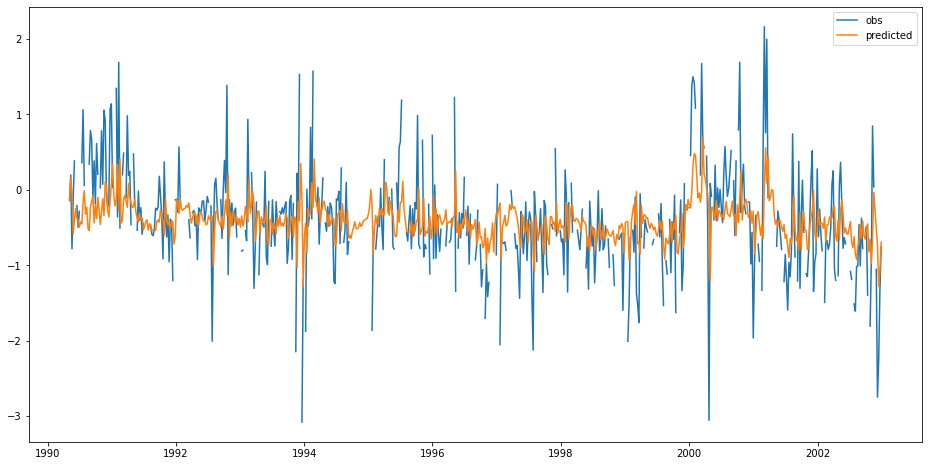

In [6]:
fig, ax = plt.subplots(figsize=(16, 8))
# col = np.random.choice(x1.columns)
col = 'ndvi_ne'
endog, exog = dfm_model[(factors, factor_orders)].format_data_arimax(x1.loc[city], y1.loc[city], interpolate=False)
# res = res_dfm.extend(endog=exog)
ax.plot(exog[col], label='obs')
ax.plot(res_dfm.predict()[col], label='predicted')
plt.legend()
plt.show()

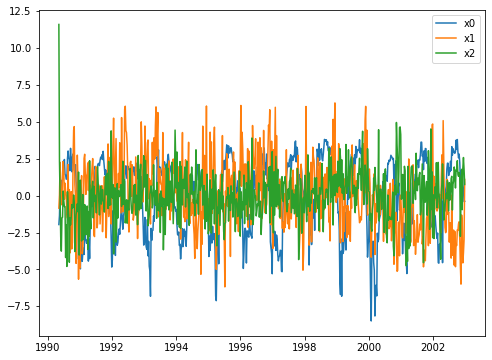

In [7]:
eta_filtered = res_dfm.factors['filtered']
eta_filtered.columns = ['x%i' % i for i in range(factors)]
eta_filtered_cov = res_dfm.factors['filtered_cov']

fig, ax = plt.subplots(figsize=(8, 6))
for factor in eta_filtered.columns:
    ax.plot(eta_filtered.index, eta_filtered[factor], label=factor)
plt.legend()
plt.show()

[x0] AR coefficient: 0.8927


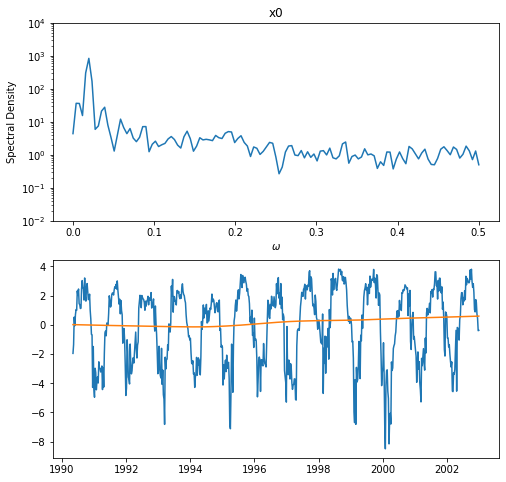

               power           t
0.019531  840.112084   51.200000
0.015625  302.865282   64.000000
0.023438  169.221862   42.666667
0.003906   36.300490  256.000000
0.007812   35.934586  128.000000
[x1] AR coefficient: 0.4188


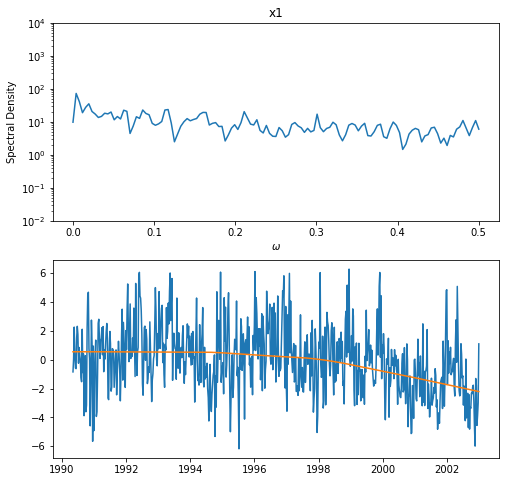

              power           t
0.003906  72.393784  256.000000
0.007812  40.862797  128.000000
0.019531  35.080572   51.200000
0.015625  27.399418   64.000000
0.117188  23.492512    8.533333
[x2] AR coefficient: 0.2149


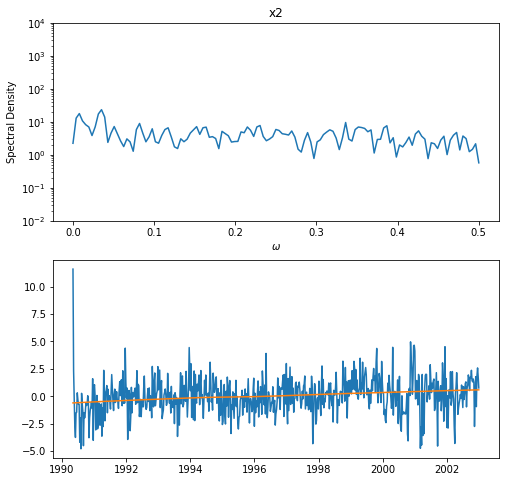

              power           t
0.035156  23.251426   28.444444
0.007812  17.740936  128.000000
0.031250  17.166768   32.000000
0.039062  13.887160   25.600000
0.003906  12.876579  256.000000


In [10]:
for i in range(factors):
    col = eta_filtered.columns[i]
    print("[x%i] AR coefficient: %.4f" % (i, res_dfm.params['L1.%i->%i' % (i,i)]))
    print(variable_analysis(eta_filtered[col], col, ylim = [1e-2, 1e4]).head())